# Diesel Price Forecasting with LSTM

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import utils

In [3]:
np.random.seed(1)

In [4]:
df = pd.read_csv('wfp_food_prices_nigeria.csv')
df.head()

,date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default
0,#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,NaN,#item+code,NaN,NaN,#item+type+code,#meta+id,NaN
1,2015-01-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
2,2015-02-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
3,2015-03-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN
4,2015-04-15,Bread - Retail,Unit,cereals and tubers,140.0,NGN,Nigeria,Adamawa,2211,Mubi,1980.0,55,15.0,33.0,1,1980_55_15_33,NaN


In [5]:
df.shape

(45577, 17)

In [6]:
df.isnull().sum()

date            0
cmname          0
unit            0
category        0
price           0
currency        0
country         0
admname         0
adm1id          0
mktname         0
mktid           1
cmid            0
ptid            1
umid            1
catid           0
sn              0
default     45577
dtype: int64

In [7]:
df['cmname'].unique()

array(['#item+name', 'Bread - Retail', 'Oil (palm) - Wholesale',
       'Oil (palm) - Retail', 'Rice (imported) - Wholesale',
       'Rice (imported) - Retail', 'Maize (white) - Wholesale',
       'Maize (white) - Retail', 'Rice (local) - Wholesale',
       'Rice (local) - Retail', 'Millet - Wholesale', 'Millet - Retail',
       'Yam - Wholesale', 'Yam - Retail',
       'Groundnuts (shelled) - Wholesale',
       'Groundnuts (shelled) - Retail', 'Sorghum (white) - Wholesale',
       'Sorghum (white) - Retail', 'Maize (yellow) - Wholesale',
       'Maize (yellow) - Retail', 'Fuel (diesel) - Retail',
       'Fuel (petrol-gasoline) - Retail', 'Cowpeas (white) - Wholesale',
       'Cowpeas (white) - Retail', 'Cowpeas (brown) - Wholesale',
       'Cowpeas (brown) - Retail', 'Sorghum (brown) - Wholesale',
       'Sorghum (brown) - Retail',
       'Cassava meal (gari, yellow) - Wholesale',
       'Cassava meal (gari, yellow) - Retail', 'Gari (white) - Wholesale',
       'Gari (white) - Retail'

I am only interested in the Diesel commodity.
It is written as 'Fuel (diesel) - Retail' under in cmname column

In [8]:
#extract the diesel price data from the main dataset
_, diesel = utils.process_data(df, 'Fuel (diesel) - Retail')
diesel.head()

,price
date,
2014-05-15,155.00
2014-07-15,160.00
2014-08-15,160.00
2014-09-15,158.50
2014-10-15,159.25


In [9]:
diesel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 2014-05-15 to 2020-11-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   77 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


In [10]:
diesel.describe()

,price
count,77.000000
mean,195.632957
std,35.050283
min,130.000000
25%,159.250000
50%,204.500000
75%,229.500000
max,262.000000


The diesel dataset has 77 entries, that is 77 months in the last 7 years (2014 - 2020).

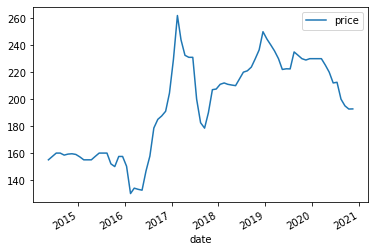

In [11]:
diesel.plot()

In [12]:
price = diesel['price'].values.reshape(-1, 1)
price[:5]

array([[155.  ],
       [160.  ],
       [160.  ],
       [158.5 ],
       [159.25]])

In [13]:
#initialize scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(price)

In [14]:
#scale data
scaled_data = scaler.transform(price)
scaled_data[:5]

array([[-0.62121212],
       [-0.54545455],
       [-0.54545455],
       [-0.56818182],
       [-0.55681818]])

In [15]:
scaled_data.shape

(77, 1)

To be able to predict with a neural network, data needs to be converted from time series to supervised learning.

This can be done by creating look back features from the data. Here, I used a lookback/ lag value of 1.

In [16]:
#make into supervised learning data
data_with_lag = utils.timeseries_to_supervised(scaled_data)
data_with_lag.columns = ['price', 'lag_1']
data_with_lag.head()

,price,lag_1
0,0.000000,-0.621212
1,-0.621212,-0.545455
2,-0.545455,-0.545455
3,-0.545455,-0.568182
4,-0.568182,-0.556818


In [17]:
#separate into feature and target sets
X, y = utils.feature_target(data_with_lag)

In [18]:
X[:5]

array([[[-0.62121212]],

       [[-0.54545455]],

       [[-0.54545455]],

       [[-0.56818182]],

       [[-0.55681818]]])

In [19]:
y[:5]

array([[ 0.        ],
       [-0.62121212],
       [-0.54545455],
       [-0.54545455],
       [-0.56818182]])

Build LSTM Model

In [20]:
model = utils.build_LSTM(X)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 1, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (1, 1, 50)                0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 100)                  60400     
_________________________________________________________________
dropout_1 (Dropout)          (1, 100)                  0         
_________________________________________________________________
dense (Dense)                (1, 1)                    101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X, y, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
77/77 [==============================] - 3s 2ms/step - loss: 0.1208
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0724
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 8/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 11/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 12/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 13/100
77/77 [=================

Text(0.5, 1.0, 'Model Accuracy')

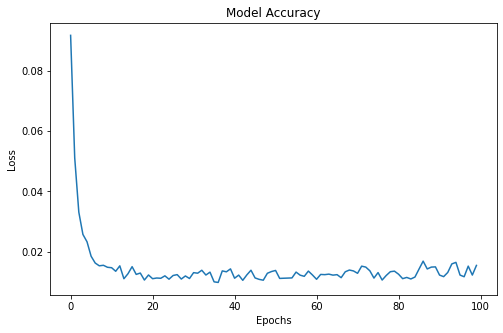

In [23]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [24]:
y_pred = model.predict(X, batch_size=1)

To check how well the model performed
- inverse transform the forecast for scaling (due to scaling that was done before model training)
- create a dataframe with the date, original price and the predicted price
- plot the data
- check metrics

In [25]:
#inverse transform prediction to get predicted price
inverted_y_pred = scaler.inverse_transform(y_pred)
inverted_y_pred[:5]

array([[173.97955],
       [163.13396],
       [156.61072],
       [152.9583 ],
       [152.23724]], dtype=float32)

In [26]:
df = pd.DataFrame()

df['date'] = diesel.index
df['price'] = list(diesel['price'])
df['predicted_price'] = inverted_y_pred
df.head()

,date,price,predicted_price
0,2014-05-15,155.00,173.979553
1,2014-07-15,160.00,163.133957
2,2014-08-15,160.00,156.610718
3,2014-09-15,158.50,152.958298
4,2014-10-15,159.25,152.237244


In [27]:
print('MSE ', mean_squared_error(df['price'], df['predicted_price']))

MSE  89.20987224121157


In [28]:
#rmse
print('RMSE ', np.sqrt(mean_squared_error(df['price'], df['predicted_price'])))

RMSE  9.445097788864421


In [29]:
print('R2 Score ', r2_score(df['price'], df['predicted_price']))

R2 Score  0.9264289451209421


In [30]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

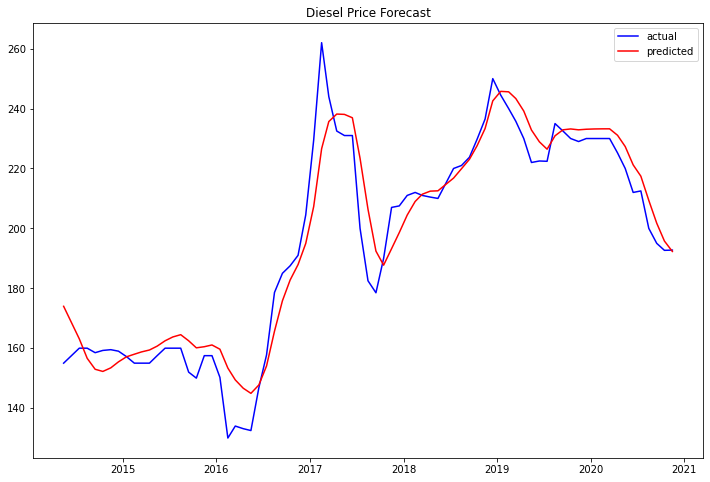

In [31]:
plt.figure(figsize=(12,8))
plt.plot(df['price'], color="blue", label="actual")
plt.plot(df['predicted_price'], color="red", label="predicted")
plt.title("Diesel Price Forecast")
plt.legend()

The model performs really well on the exsiting dataset with an RMSE score of 9.44 and R2 Score of 92.64%.

I can confidently use this model to forecast future data.

## Future Prediction

I will be predicting diesel prices 3 years into the future, 2021, 2022, 2023. That is 36 months.

In [32]:
#3 years, 36 months
num_prediction = 36

#past price data
price_data = scaler.transform([diesel['price']]).reshape(-1)
price_data[:5]

array([-0.62121212, -0.54545455, -0.54545455, -0.56818182, -0.55681818])

In [33]:
price_data.shape

(77,)

In [34]:
#forecast future prices
forecast = utils.forecast(num_prediction, model, price_data, look_back=1)
forecast_dates = utils.forecast_dates(diesel, num_prediction, frequency = 'MS')

In [35]:
forecast_dates[:5]

[Timestamp('2020-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'),
 Timestamp('2021-02-01 00:00:00', freq='MS'),
 Timestamp('2021-03-01 00:00:00', freq='MS'),
 Timestamp('2021-04-01 00:00:00', freq='MS')]

In [36]:
forecast

array([-0.04924242, -0.0819    , -0.10502267, -0.12461655, -0.14190777,
       -0.15786213, -0.1732118 , -0.18849102, -0.2040631 , -0.22014378,
       -0.23682036, -0.2540701 , -0.27177536, -0.28973967, -0.3077023 ,
       -0.32535475, -0.34235734, -0.35835898, -0.37301666, -0.38601619,
       -0.39709336, -0.4060505 , -0.41277069, -0.41722584, -0.41947728,
       -0.41967148, -0.41802776, -0.41482073, -0.41036141, -0.40497494,
       -0.39898145, -0.39267838, -0.38632798, -0.38014925, -0.37431461,
       -0.36894906, -0.36413503])

In [37]:
len(forecast_dates)

37

In [38]:
#inverse transform forecast and reshape
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))
forecast

array([[192.75      ],
       [190.59459996],
       [189.06850386],
       [187.7753078 ],
       [186.63408741],
       [185.58109963],
       [184.56802133],
       [183.5595929 ],
       [182.53183523],
       [181.47051051],
       [180.36985657],
       [179.23137319],
       [178.06282592],
       [176.87718189],
       [175.69164801],
       [174.52658617],
       [173.40441573],
       [172.34830737],
       [171.38090074],
       [170.52293146],
       [169.79183853],
       [169.20066679],
       [168.75713456],
       [168.46309471],
       [168.31449926],
       [168.30168259],
       [168.41016793],
       [168.62183177],
       [168.91614699],
       [169.27165413],
       [169.66722417],
       [170.08322692],
       [170.50235319],
       [170.91014981],
       [171.29523599],
       [171.64936233],
       [171.96708822]])

In [39]:
len(forecast)

37

In [40]:
future = pd.DataFrame()

future['date'] = list(forecast_dates)
future['predicted_price'] = forecast
future.set_index('date', inplace=True)
future.index = pd.to_datetime(future.index)
future.head()

,predicted_price
date,
2020-12-01,192.750000
2021-01-01,190.594600
2021-02-01,189.068504
2021-03-01,187.775308
2021-04-01,186.634087


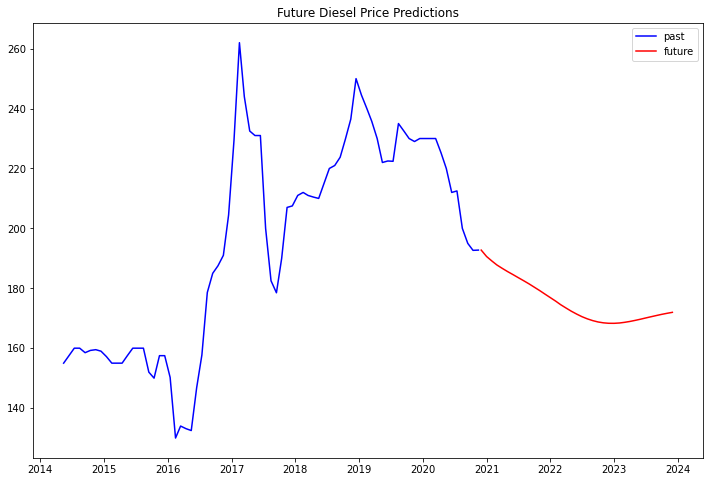

In [41]:
plt.figure(figsize=(12,8))

plt.plot(diesel ['price'], c='blue', label="past")
plt.plot(future['predicted_price'], c='red', label="future")
plt.title('Future Diesel Price Predictions')
plt.legend()

## Conclusion
The model performed really well on existing data with an r2 score of 94.58%.

The model has forecasted that diesel prices would reduce in 3 years time.

(but as a Nigerian living in Nigeria I do not believe this at all.)